### Import the data into a DataFrame, split the data into features and target and inspect the distribution of the GradeClass.

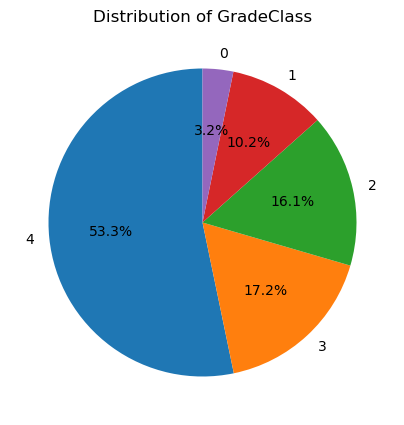

Class distribution:
GradeClass
4    1274
3     412
2     385
1     244
0      77
Name: count, dtype: int64


In [1]:
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

df = pd.read_csv("../data/processed/engineered_data.csv")

x = df.drop(columns=["GradeClass"])
y = df["GradeClass"]

y.value_counts().plot.pie(autopct='%1.1f%%', startangle=90, figsize=(5, 5))
plt.title("Distribution of GradeClass")
plt.ylabel("")  # Hide the y-label
plt.show()

print("Class distribution:")
print(y.value_counts())

### Seeing that the distribution of GradeClass is extremely unbalanced perform undersampling, oversampling and a hybrid of both to even out the distribution.

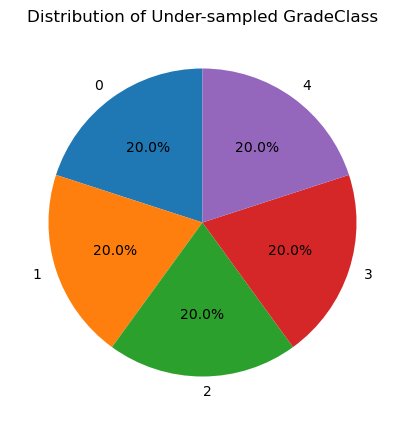

Class distribution:
GradeClass
0    77
1    77
2    77
3    77
4    77
Name: count, dtype: int64


In [17]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTEENN
from imblearn.combine import SMOTETomek
from imblearn.over_sampling import ADASYN

# Random Under Sampling
# Define the desired number of samples for each class
sampling_strategy = {
    0: 77,  # Class 0 samples
    1: 77,  # Class 1 samples
    2: 77,  # Class 2 samples
    3: 77,   # Class 3 samples
    4: 77   # Class 4 samples
}

rus = RandomUnderSampler(sampling_strategy = sampling_strategy, random_state=42)
X_rus, y_rus = rus.fit_resample(x, y)

# Visualize the results
y_rus.value_counts().plot.pie(autopct='%1.1f%%', startangle=90, figsize=(5, 5))
plt.title("Distribution of Under-sampled GradeClass")
plt.ylabel("")  # Hide the y-label
plt.show()

print("Class distribution:")
print(y_rus.value_counts())


### Split the under-sampled data into Training and Testing data

In [3]:
from sklearn.model_selection import train_test_split

X_rus_train, X_rus_test, y_rus_train, y_rus_test = train_test_split(X_rus, y_rus, test_size=0.2, random_state=42)

### Now perform the basic logistic regression on the random under-sampled data.

In [9]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

# Scale the features
scaler = StandardScaler()
X_rus_train_scaled = scaler.fit_transform(X_rus_train)
X_rus_test_scaled = scaler.transform(X_rus_test)

# Train logistic regression for multi-class classification
log_reg = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=42)
log_reg.fit(X_rus_train_scaled, y_rus_train)

# Predict
y_pred = log_reg.predict(X_rus_test_scaled)

# Evaluation
print("Accuracy:", accuracy_score(y_rus_test, y_pred))
print("Classification Report:\n", classification_report(y_rus_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_rus_test, y_pred))

# Feature Importance (Coefficients for each class)
coeffs = pd.DataFrame(log_reg.coef_, columns=X_rus.columns)
coeffs['Class'] = log_reg.classes_

# Melt the DataFrame to make it easier to read
coeff_melted = coeffs.melt(id_vars='Class', var_name='Feature', value_name='Coefficient')
coeff_sorted = coeff_melted.sort_values(by='Coefficient', key=np.abs, ascending=False)

print("Top Feature Coefficients across classes:\n", coeff_sorted.head(12))


Accuracy: 0.6623376623376623
Classification Report:
               precision    recall  f1-score   support

           0       0.71      0.68      0.70        22
           1       0.57      0.60      0.59        20
           2       0.50      0.33      0.40         9
           3       0.62      0.77      0.69        13
           4       0.85      0.85      0.85        13

    accuracy                           0.66        77
   macro avg       0.65      0.65      0.64        77
weighted avg       0.66      0.66      0.66        77

Confusion Matrix:
 [[15  7  0  0  0]
 [ 6 12  2  0  0]
 [ 0  2  3  4  0]
 [ 0  0  1 10  2]
 [ 0  0  0  2 11]]
Top Feature Coefficients across classes:
     Class          Feature  Coefficient
29      4         Absences     5.214256
25      0         Absences    -4.907812
26      1         Absences    -2.358922
28      3         Absences     2.202616
35      0  ParentalSupport     1.298432
24      4  StudyTimeWeekly    -1.138455
39      4  ParentalSupport

### Now perform Baseline Random Forrest on the under-sampled data.

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Train/test split (only if not already done)
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 2: Baseline Random Forest
rf_clf = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_clf.fit(X_rus_train, y_rus_train)

# Step 3: Predictions
y_pred = rf_clf.predict(X_rus_test)

# Step 4: Evaluation
accuracy = accuracy_score(y_rus_test, y_pred)
print(f"Accuracy: {accuracy}")
print("Classification Report:\n", classification_report(y_rus_test, y_pred))


Accuracy: 0.6103896103896104
Classification Report:
               precision    recall  f1-score   support

           0       0.68      0.77      0.72        22
           1       0.55      0.30      0.39        20
           2       0.33      0.67      0.44         9
           3       0.67      0.46      0.55        13
           4       0.86      0.92      0.89        13

    accuracy                           0.61        77
   macro avg       0.62      0.62      0.60        77
weighted avg       0.63      0.61      0.60        77



### Now perform Hyperparameter Tuning (RandomizedSearchCV) on the under-sampled data.

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best Parameters: {'n_estimators': 100, 'min_samples_split': 5, 'min_samples_leaf': 4, 'max_depth': 10, 'bootstrap': False}
Test Accuracy: 0.6363636363636364
Classification Report:
               precision    recall  f1-score   support

           0       0.62      0.73      0.67        22
           1       0.86      0.30      0.44        20
           2       0.35      0.67      0.46         9
           3       0.75      0.69      0.72        13
           4       0.80      0.92      0.86        13

    accuracy                           0.64        77
   macro avg       0.68      0.66      0.63        77
weighted avg       0.70      0.64      0.63        77



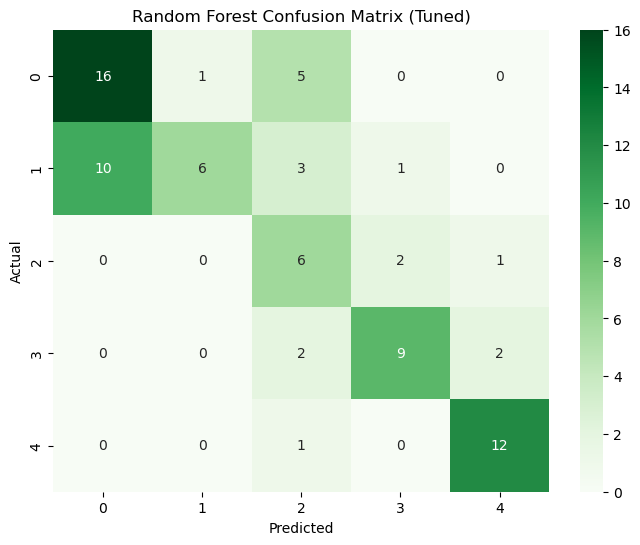

In [12]:
from sklearn.model_selection import RandomizedSearchCV
import numpy as np

# Define parameter grid
param_dist = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30, 40],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Setup random search
rf_random = RandomizedSearchCV(
    estimator=RandomForestClassifier(random_state=42, n_jobs=-1),
    param_distributions=param_dist,
    n_iter=50,
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1
)

# Fit to training data
rf_random.fit(X_rus_train, y_rus_train)

# Best model
best_rf = rf_random.best_estimator_

# Predict
y_pred_best = best_rf.predict(X_rus_test)

# Evaluate
print("Best Parameters:", rf_random.best_params_)
print("Test Accuracy:", accuracy_score(y_rus_test, y_pred_best))
print("Classification Report:\n", classification_report(y_rus_test, y_pred_best))


### Now, since the under-sampling didn't improve the accuracy, let's try over-sampling

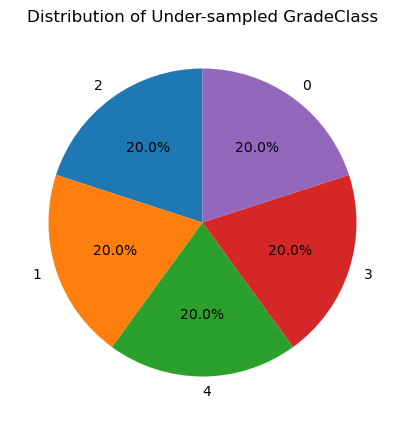

Class distribution:
GradeClass
2    1274
1    1274
4    1274
3    1274
0    1274
Name: count, dtype: int64


In [18]:
from imblearn.over_sampling import RandomOverSampler

# Define the desired number of samples for each class
sampling_strategy = {
    0: 1274,  # Class 0 samples
    1: 1274,  # Class 1 samples
    2: 1274,  # Class 2 samples
    3: 1274,   # Class 3 samples
    4: 1274   # Class 4 samples
}

ros = RandomOverSampler(sampling_strategy=sampling_strategy, random_state=42)

X_ros, y_ros = ros.fit_resample(x, y)

# Visualize the results
y_ros.value_counts().plot.pie(autopct='%1.1f%%', startangle=90, figsize=(5, 5))
plt.title("Distribution of Under-sampled GradeClass")
plt.ylabel("")  # Hide the y-label
plt.show()

print("Class distribution:")
print(y_ros.value_counts())

### Split the over-sampled data into Training and Testing data

In [23]:
from sklearn.model_selection import train_test_split

X_ros_train, X_ros_test, y_ros_train, y_ros_test = train_test_split(X_ros, y_ros, test_size=0.2, random_state=42, stratify=y_ros)

### Now perform the basic logistic regression on the random over-sampled data.

In [20]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

# Scale the features
scaler = StandardScaler()
X_ros_train_scaled = scaler.fit_transform(X_ros_train)
X_ros_test_scaled = scaler.transform(X_ros_test)

# Train logistic regression for multi-class classification
log_reg = LogisticRegression(solver='lbfgs', max_iter=1000, random_state=42)
log_reg.fit(X_ros_train_scaled, y_ros_train)

# Predict
y_pred = log_reg.predict(X_ros_test_scaled)

# Evaluation
print("Accuracy:", accuracy_score(y_ros_test, y_pred))
print("Classification Report:\n", classification_report(y_ros_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_ros_test, y_pred))

# Feature Importance (Coefficients for each class)
coeffs = pd.DataFrame(log_reg.coef_, columns=X_ros.columns)
coeffs['Class'] = log_reg.classes_

# Melt the DataFrame to make it easier to read
coeff_melted = coeffs.melt(id_vars='Class', var_name='Feature', value_name='Coefficient')
coeff_sorted = coeff_melted.sort_values(by='Coefficient', key=np.abs, ascending=False)

print("Top Feature Coefficients across classes:\n", coeff_sorted.head(12))

Accuracy: 0.7629513343799058
Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.82      0.81       245
           1       0.69      0.67      0.68       243
           2       0.67      0.66      0.66       258
           3       0.71      0.75      0.73       267
           4       0.95      0.90      0.93       261

    accuracy                           0.76      1274
   macro avg       0.76      0.76      0.76      1274
weighted avg       0.76      0.76      0.76      1274

Confusion Matrix:
 [[201  44   0   0   0]
 [ 48 164  31   0   0]
 [  2  29 171  56   0]
 [  0   0  55 200  12]
 [  0   0   0  25 236]]
Top Feature Coefficients across classes:
     Class          Feature  Coefficient
25      0         Absences   -11.009307
29      4         Absences    10.958796
26      1         Absences    -5.490204
28      3         Absences     5.256656
35      0  ParentalSupport     2.363696
24      4  StudyTimeWeekly    -2.288590
3

## The over-sampling drastically improved the recall and f1-score of classes 0, 1 and 2. But it decreased the recall and f1-scores of 3 and 4.

### Now perform Baseline Random Forrest on the over-sampled data.

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Train/test split (only if not already done)
# from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Step 2: Baseline Random Forest
rf_clf = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_clf.fit(X_ros_train, y_ros_train)

# Step 3: Predictions
y_pred = rf_clf.predict(X_ros_test)

# Step 4: Evaluation
accuracy = accuracy_score(y_ros_test, y_pred)
print(f"Accuracy: {accuracy}")
print("Classification Report:\n", classification_report(y_ros_test, y_pred))

Accuracy: 0.967032967032967
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       255
           1       0.99      1.00      1.00       254
           2       0.96      0.98      0.97       255
           3       0.91      0.95      0.93       255
           4       0.98      0.91      0.94       255

    accuracy                           0.97      1274
   macro avg       0.97      0.97      0.97      1274
weighted avg       0.97      0.97      0.97      1274



In [26]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Original train/test split (on original, imbalanced data)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42, stratify=y)

# Step 2: Apply RandomOverSampler only on the training data
sampling_strategy = {
    0: 1274,
    1: 1274,
    2: 1274,
    3: 1274,
    4: 1274
}
ros = RandomOverSampler(sampling_strategy=sampling_strategy, random_state=42)
X_train_ros, y_train_ros = ros.fit_resample(X_train, y_train)

# Step 3: Train Random Forest on oversampled training data
rf_clf = RandomForestClassifier(random_state=42, n_jobs=-1)
rf_clf.fit(X_train_ros, y_train_ros)

# Step 4: Predict on original (untouched) test set
y_pred = rf_clf.predict(X_test)

# Step 5: Evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print("Classification Report:\n", classification_report(y_test, y_pred))


Accuracy: 0.7661795407098121
Classification Report:
               precision    recall  f1-score   support

           0       0.56      0.33      0.42        15
           1       0.60      0.57      0.58        49
           2       0.58      0.62      0.60        77
           3       0.56      0.65      0.60        83
           4       0.95      0.91      0.93       255

    accuracy                           0.77       479
   macro avg       0.65      0.62      0.63       479
weighted avg       0.78      0.77      0.77       479



In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from collections import Counter
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Apply SMOTE to full dataset
smote = SMOTE(random_state=42)
X_sm, y_sm = smote.fit_resample(x, y)

print("Resampled class distribution:", Counter(y_sm))

# Step 2: Split into train/test with stratified sampling
X_train, X_test, y_train, y_test = train_test_split(
    X_sm, y_sm, test_size=0.2, random_state=42, stratify=y_sm)

# Step 3: Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 4: XGBoost with better tuning
xgb_clf = XGBClassifier(
    objective='multi:softprob',
    num_class=5,
    learning_rate=0.05,
    max_depth=6,
    n_estimators=500,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_lambda=1,
    reg_alpha=0.5,
    random_state=42
)

xgb_clf.fit(X_train_scaled, y_train)

# Step 5: Predict and Evaluate
y_pred = xgb_clf.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred)
print(f"\nAccuracy: {accuracy:.4f}\n")
print("Classification Report:\n", classification_report(y_test, y_pred))

Resampled class distribution: Counter({2: 1274, 1: 1274, 4: 1274, 3: 1274, 0: 1274})

✅ Accuracy: 0.9042

📊 Classification Report:
               precision    recall  f1-score   support

           0       0.96      1.00      0.98       255
           1       0.90      0.92      0.91       254
           2       0.88      0.83      0.85       255
           3       0.84      0.88      0.86       255
           4       0.95      0.89      0.92       255

    accuracy                           0.90      1274
   macro avg       0.90      0.90      0.90      1274
weighted avg       0.90      0.90      0.90      1274



In [ ]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Train-test split on original data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=42
)

# Step 2: Apply SMOTE only on training data
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# Optional: Check new distribution
from collections import Counter
print("Resampled train distribution:", Counter(y_train_smote))

# Step 3: Train your model
model = RandomForestClassifier(random_state=42)
model.fit(X_train_smote, y_train_smote)

# Step 4: Predict on original test set
y_pred = model.predict(X_test)

# Step 5: Evaluation
print("Accuracy:", round(accuracy_score(y_test, y_pred), 4))
print("\nClassification Report:\n", classification_report(y_test, y_pred))

Resampled train distribution: Counter({4: 1019, 1: 1019, 2: 1019, 0: 1019, 3: 1019})
✅ Accuracy: 0.7307

📊 Classification Report:
               precision    recall  f1-score   support

           0       0.35      0.47      0.40        15
           1       0.54      0.59      0.56        49
           2       0.62      0.58      0.60        77
           3       0.49      0.59      0.54        83
           4       0.95      0.86      0.90       255

    accuracy                           0.73       479
   macro avg       0.59      0.62      0.60       479
weighted avg       0.75      0.73      0.74       479



In [34]:
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import uniform, randint

# 1. Load your data (replace with your actual dataset)
# X, y = your dataset features and labels

# 2. Train/test split (use original data here)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 3. SMOTE (apply it only to the training set)
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

# 4. Define the XGBoost model with class weight balancing
xgb_model = xgb.XGBClassifier(
    objective='multi:softmax',  # For multi-class classification
    num_class=5,  # Adjust based on your class count
    use_label_encoder=False,
    random_state=42,
    eval_metric='mlogloss'
)

# 5. Hyperparameter tuning using RandomizedSearchCV
param_dist = {
    'max_depth': randint(3, 15),
    'n_estimators': randint(100, 500),
    'learning_rate': uniform(0.01, 0.2),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
}

random_search = RandomizedSearchCV(xgb_model, param_distributions=param_dist, n_iter=100, cv=3, verbose=1, n_jobs=-1, scoring='accuracy', random_state=42)
random_search.fit(X_train_smote, y_train_smote)

# 6. Best model from random search
best_model = random_search.best_estimator_

# 7. Predict on the original, imbalanced test data
y_pred = best_model.predict(X_test)

# 8. Evaluation
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print("Classification Report:\n", classification_report(y_test, y_pred))

Fitting 3 folds for each of 100 candidates, totalling 300 fits


c:\Users\juano\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [18:11:15] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


Accuracy: 0.732776617954071
Classification Report:
               precision    recall  f1-score   support

           0       0.33      0.47      0.39        15
           1       0.52      0.57      0.54        49
           2       0.58      0.58      0.58        77
           3       0.52      0.59      0.55        83
           4       0.96      0.87      0.91       255

    accuracy                           0.73       479
   macro avg       0.58      0.62      0.60       479
weighted avg       0.76      0.73      0.74       479

